# Part 1: Preparation - Practical python for neural networks

The goal of this notebook is to introduce helpful python for getting started.
We will be relying mostly on Image() from Python Image Library (PIL) and many parts of numpy, so load those up. 

Useful functions in Image(): .fromarray(), .resize(), .save(). 

Easily switch to numpy array with np.asarray() and back again with Image.fromarray().

In [55]:
import numpy as np
from PIL import Image
import matplotlib
%matplotlib inline

imgfile='digilabs.jpg'
img_pil = Image.open(imgfile)
img_np = np.asarray(img_pil)
print('Image shape: ', img_np.shape)
img_pil_again = Image.fromarray(img_np)

Image shape:  (358, 840, 3)


Resample to half the size of the original image, or to some desired image size.

In [56]:
down_size = [shape//2 for shape in img_np.shape[:2]]
img_pil_halfsize = img_pil_again.resize(down_size, Image.NEAREST)
print('Halved image shape: ', img_pil_halfsize.size)
img_pil_halfsize.save(imgfile.replace('.jpg','_halved.jpg'), 'JPEG')
img_pil_224= img_pil_again.resize((224,224), Image.NEAREST)
img_pil_224.save(imgfile.replace('.jpg','_224.jpg'), 'JPEG')

Halved image shape:  (179, 420)


Display image, histogram, image stats.

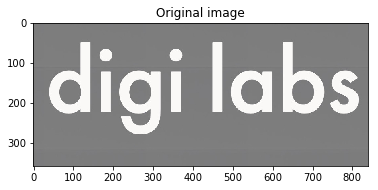

In [57]:
import matplotlib.pylab as plt
plt.figure()
plt.imshow(img_np)
plt.title('Original image')
plt.show()

Scale image to 0-1 range (np.ptp is like range() in matlab - it is the max minus min)

min, mean, max scaled:  [0.0, 0.22855783053379247, 1.0]


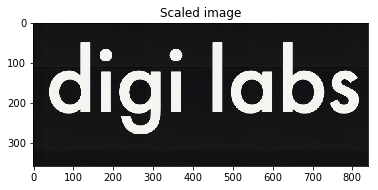

In [58]:
img_np_scaled = (img_np - np.min(img_np))/np.ptp(img_np)
print('min, mean, max scaled: ', [np.min(img_np_scaled), np.mean(img_np_scaled), np.max(img_np_scaled)])
plt.imshow(img_np_scaled)
plt.title('Scaled image')
plt.show()
plt.pause(4)
plt.close()

Use histogramming to get a quick sense of the data distribution(s).
This can be useful for finding problems and understanding what methods are more appropriate

Histogram of random data 0-1 and 0-2 overlain
Histogram of random data 0-1 and 0-2 using the same bins as first plot


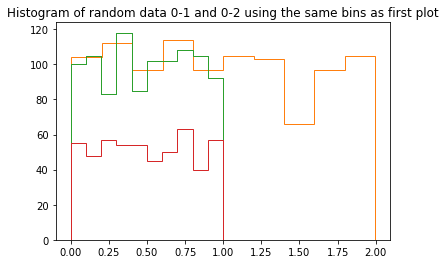

In [59]:
plt.figure()
data=np.random.random((1000,1))
plt.hist(data,histtype='step')
data2=2*np.random.random((1000,1))
plt.hist(data2,histtype='step')
plt.title('Histogram of random data 0-1 and 0-2 overlain')
print('Histogram of random data 0-1 and 0-2 overlain')

(n,x,_)=plt.hist(data,histtype='step')
plt.hist(data2,x, histtype='step')
plt.title('Histogram of random data 0-1 and 0-2 using the same bins as first plot')
print('Histogram of random data 0-1 and 0-2 using the same bins as first plot')

Notice the bin size and range are very important. For practical purposes, you will often have to play with bin sizes to "see" what's going on, and other times you may have to play with cutoffs (specify the range to bin over) to prevent a bin from obliterating visibility on any other bin. There is no "perfect" bin size, just useful bin sizes.

Next, try some basic operations in numpy. Below, the dot_prod shows a simple fully-connected neuron layer operating on input data, implementing the equation: $$ feature\_map = w * x + b $$


In this example, the input data might be the famous MNIST digit dataset where every image is a grayscale 28x28 image of a handwritten digit.

In [60]:
# Numpy basics, np.dot
data = np.random.random((28,28))
data = data.reshape((784,1))
# inner product dot(IxJ, JxK) -> IxK
weights = np.random.randn(10, 784)
offsets = np.random.randn(10, 1)
dot_prod = np.dot(weights,data) + offsets

Convolutions will come from another package, scipy.signal. First define an edge-detecting filter (2 channels) to apply to a 3-channel input image.

In [61]:
from scipy import signal
l1_filter = np.zeros((2,3,3))
l1_filter[0, :, :] = np.array([[[-1, 0, 1],
                                [-1, 0, 1],
                                [-1, 0, 1]]])
l1_filter[1, :, :] = np.array([[[1,   1,  1],
                                [0,   0,  0],
                                [-1, -1, -1]]])
img=np.asarray(img_pil_224)
print('Filter shape: ', l1_filter.shape)
print('Image shape: ', img.shape)

Filter shape:  (2, 3, 3)
Image shape:  (224, 224, 3)


In [62]:
# convert a 3-channel input to a 2-channel output by passing thru a 2-channel 3x3 filter
img_pad = np.pad(img,
                 pad_width=l1_filter.shape[2]//2,
                 mode='constant',
                 constant_values=0).astype(np.float64)
print('Padded image', img_pad.shape)
fmap = np.zeros((l1_filter.shape[0],img_pad.shape[0],img_pad.shape[1])).astype(np.float64)
print('Feature map shape: ', fmap.shape)

Padded image (226, 226, 5)
Feature map shape:  (2, 226, 226)


Apply the filter manually by looping over indices. Look at the indexing in the innermost operation. We reverse indices because that is what convolution is!

In [63]:
for c in range(l1_filter.shape[0]):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for in_channel in range(img.shape[2]):
                for m in range(l1_filter.shape[1]):
                    for n in range(l1_filter.shape[2]):
                        # note, convolution is applied in opposite direction as data
                        fmap[c, i, j] += img_pad[i + m, j + n, in_channel] * \
                          l1_filter[c, l1_filter.shape[1]-m-1, l1_filter.shape[2]-n-1]
                        # this will have implications for backpropagation for convolutions

Alternatively, use an optimized function from scipy to do it in one line. Look at the "feature map" output of both the big looped implementation and scipy's implementation.

Feature map shape:  (2, 226, 226)
Same, but oneline (2, 226, 226)


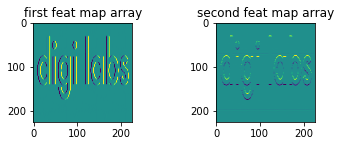

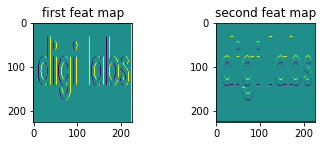

In [64]:
fmap_oneline = np.asarray([sum([signal.convolve2d(img[:,:,in_channel], filt) \
                                for in_channel in range(3)]) for filt in l1_filter])
print('Feature map shape: ', fmap.shape)
print('Same, but oneline', fmap_oneline.shape)

plt.figure()
plt.subplot(2,2,1)
plt.imshow(fmap[0,:,:])
plt.title('first feat map array')
plt.subplot(2,2,2)
plt.imshow(fmap[1,:,:])
plt.title('second feat map array')
plt.show()
plt.subplot(2,2,3)
plt.imshow(fmap_oneline[0,:,:])
plt.title('first feat map')
plt.subplot(2,2,4)
plt.imshow(fmap_oneline[1,:,:])
plt.title('second feat map')
plt.pause(6)

************************************************************************

Next, lets look at some more practical python. List (and set) comprehension, and more complicated things you can do, like flow control inside the one-liner. Get used to these and you will experience a great improvement in your enjoyment with python.

In [65]:
nums = range(10)
print(nums)
squared_num_list = [x**2 for x in range(10)]
squared_num_dict = {x: x**2 for x in range(10)}
# sets exclude more than one of the same member, can be useful for one-liners that also exclude duplicates
squared_num_set = set(x**2 for x in range(10))

# flow control inside comprehension expression
squared_evens = [x**2 for x in range(10) if x%2 == 0]
# double loops (left loop is the outer loop)
doubled_list=[[0,1,2], [3], [4,5,6], [7,8], [9,10,11,12,13]]
doubled_list = [[i for i in range(x)] for x in range(5)]
flattened_list = [y for x in doubled_list for y in x]
flattened_set = set(y for x in doubled_list for y in x)

range(0, 10)



Same goes for lambdas. These are useful for condensing complex code quickly, as well as for passing simple functions as arguments without having to define them ahead of time.

In [66]:
# Lambdas for simple purposes
imread = lambda imgfile: np.array(Image.open(imgfile))
imwrite = lambda img,imgfile: Image.fromarray(img).save(imgfile,'JPEG')
# nan-safe version of normalize_image
normalize_image = lambda img: (img-np.nanmin(img))/(np.nanmax(img)-np.nanmin(img)) \
   if np.nanmax(img) > 0.0 else img

# Least-squares fitting in biomedical data

We are going to load functional MRI data and analyse it in python.

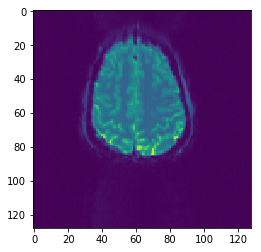

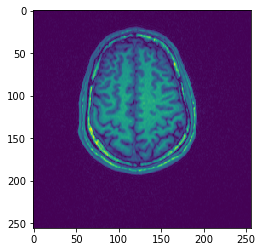

In [67]:
motor_slice=np.load('motor_slice.npy')
mprage_slice=np.load('brain_slice.npy')
mprage_slice = 255*mprage_slice.astype(np.float)/np.max(mprage_slice)
tseries=motor_slice[78,64,:]
tseries=(tseries-np.min(tseries))/np.ptp(tseries)
plt.imshow(motor_slice[:,:,0].transpose())
plt.show()
plt.imshow(mprage_slice.transpose())
plt.show()

The array mprage_slice is a high-resolution brain image while the motor_slice is a lower-resolution functional scan of 160 volumes taken while the subject moved their hands in an off/on pattern. Slices were chosen to show the hand motor cortex.

Next, we'll build a model for the brain function and plot this model with a selected voxel in the hand motor knob area. We know the times when the subject was moving hands, so we'll build a regressor_func for this, but we also have to account for other sources of variance. For least-squares, any non-zero mean in a regressor will fit to any non-zero mean in the data, so we either zero-mean our data or include a regressor for the mean. This is made up of ones, the amplitude of the fit to the meanval regressor should be equal to the mean value of the data). Secondly, MRI data tends to drift due to heating, so we also include a trendline. This should also be zero-meaned, if we don't you'll see the amplitude change and the resulting statistics will be biased.

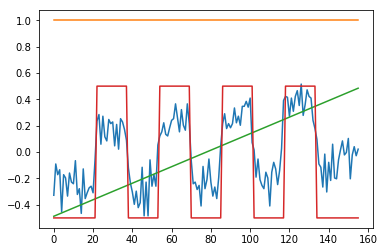

In [68]:
# regressors
regressor_meanval = np.ones((160,))
regressor_trend = (np.arange(160)/159.5)-0.5
regressor_func = np.concatenate([np.zeros((24,)), np.ones((16,)), np.zeros((16,)), np.ones((16,)), np.zeros((16,)), np.ones((16,)),np.zeros((16,)), np.ones((16,)), np.zeros((24,))])-0.5
regressors=np.asarray([ regressor_meanval, regressor_trend, regressor_func]).transpose()

# remove first four for saturation
tseries=tseries[4:]
# shifting the regressors for hemodynamic delay of ~6 sec so remove first two and last two
regressors=regressors[2:-2,:]
plt.plot((tseries - np.mean(tseries))/np.ptp(tseries))
plt.plot(regressors)
plt.show()

Use numpy.linalg.lstsq(A,b) to do a least-squares fit to the equation $Ax = b$. So the regressors are the model A for the data b, and the least-squares algorithm will attempt to balance variance amongst regressors to best match the data b. 

Then convert the amplitude and pooled variance to a t-statistic following: $$ t = \frac{amp}{pooled_var}$$

Fitted amplitudes:  [0.16118489 0.07906761 0.1338276 ]
T-statistic:  3.696728127828479


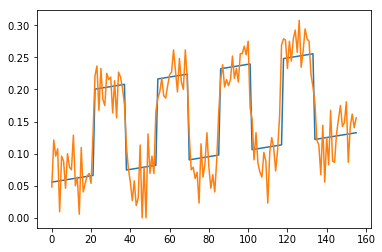

In [69]:
# least-squares fitting
fits,res,rnk,s = np.linalg.lstsq(regressors, tseries, rcond=None)
print('Fitted amplitudes: ',fits)
fitted_regs = np.sum(regressors*fits.reshape((1,3)), axis=1)
pooled_var = np.std(tseries-fitted_regs)
tstat = fits[-1]/pooled_var
print('T-statistic: ',tstat)
plt.plot(fitted_regs)
plt.plot(tseries)
plt.show()

Perform least-squares fitting on the entire slice and create a map of t-statistics.

/Users/erikbeall/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


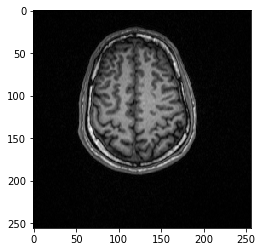

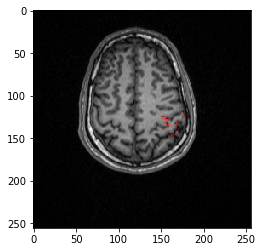

In [81]:
# do for entire slice and create t-stat map
slice_data = motor_slice[:,:,4:].reshape((128*128,156)).transpose()
fits = np.linalg.lstsq(regressors, slice_data, rcond=None)
fitted_regs = np.asarray([np.sum(regressors*fit.reshape((1,3)), axis=1) for fit in fits[0].transpose()])

pooled_vars = np.nanstd(slice_data-fitted_regs.transpose(), axis=0)
amplitudes=fits[0][2]

tstats=amplitudes/pooled_vars
tstats[np.isnan(tstats)]=0.0
tstats = tstats.reshape((128,128))

# set thresholds and combine images
brain=mprage_slice.astype(np.uint8)
mask=np.copy(brain)
# upsample tstat by simple nn-up
tstats_matched = tstats.repeat(2, axis=0).repeat(2, axis=1)
mask[abs(tstats_matched)>2.0] = (250*tstats_matched[abs(tstats_matched)>2.0]/np.max(tstats_matched)).astype(np.uint8)

# transpose for display
brain = brain.transpose()
mask = mask.transpose()

brain=np.expand_dims(brain,-1)
mask=np.expand_dims(mask,-1)
plt.imshow(np.concatenate([brain, brain, brain], axis=2))
plt.show()
plt.imshow(np.concatenate([mask, brain, brain], axis=2))
plt.show()